<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Brachistochrone_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from math import sqrt
from scipy import integrate
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import newton

"""GLOBAL VARIABLES"""
# Constant for setting figsize
GOLDEN = (1 + 5 ** 0.5) / 2

# DNA constants
MUTATION_RATE = 0.25
BASES = 10

# Make the endpoints P1 and P2
P1 = (0, 0)
P2 = (2, -1)

print("Done constants.py")

Done constants.py


In [10]:
# Linearly interpolate the two points
def linear():
    x = [p[0] for p in [P1, P2]]
    y = [p[1] for p in [P1, P2]]
    f_linear = interp1d(x, y, kind='linear')
    def dt(x):
        return np.sqrt((1 + ((P2[1] - P1[1]) / (P2[0] - P1[0]))**2) / (-f_linear(x)))
    T = integrate.quad(dt, a=P1[0], b=P2[0], limit=10)[0]
    return f_linear, T

def cycloid():
    """Return the path of Brachistochrone curve from (0,0) to (x2, y2).
    The Brachistochrone curve is the path down which a bead will fall without
    friction between two points in the least time (an arc of a cycloid).
    It is returned as an array of N values of (x,y) between (0,0) and (x2,y2).
    """

    # First find theta2 from (x2, y2) numerically (by Newton-Rapheson).
    f = lambda theta: -P2[1]/P2[0] - (1-np.cos(theta))/(theta-np.sin(theta))
    theta2 = newton(f, np.pi/2)

    # The radius of the circle generating the cycloid.
    R = -P2[1] / (1 - np.cos(theta2))

    theta = np.linspace(0, theta2, 100)
    x = R * (theta - np.sin(theta))
    y = R * (1 - np.cos(theta))

    # The time of travel
    T = theta2 * np.sqrt(R)
    return x, -y, T

"""Constants"""
f_linear, T_linear = linear()
x, y, T_cycloid = cycloid()

print("Done curves.py")

Done curves.py


In [12]:
class DNA():
    """A class holding the function and geneology of a path."""

    def __init__(self, external_DNA=None, mutation_rate=MUTATION_RATE, bases=BASES):

        # Constants
        self.mutation_rate = MUTATION_RATE
        self.bases = BASES

        # Make a path
        self.x = np.linspace(P1[0], P2[0], self.bases)
        if external_DNA == None:
            genes = self.intialize_DNA()
        else:
            genes = external_DNA

        # Assign the x-coords, y-coods, and function as attributes
        self.y = genes[0]
        self.f = genes[1]

    def intialize_DNA(self):
        """Returns a path for the particle to follow."""

        # Make the domain
        y = [P1[1], P2[1]]
        for coord in self.x[1:-1]:
            y.insert(-1, f_linear(coord) + (-2 * np.random.uniform()))

        # Iterpolate the data (x, y) to create the path
        f = UnivariateSpline(self.x, y, k=4, s=0)

        # Return x-coords, y-coords, and interpolated function
        return [y, f]

    def reproduce(self, partner):
        """Returns a genetic offspring of two paths."""

        # Create child's y-path
        child_y = [P1[1], P2[1]]
        for i in range(BASES - 2):
            nucleotide = np.random.choice([self, partner]).y[i + 1]
            child_y.insert(-1, nucleotide)

        # Mutate the child's y-path
        for coord in self.x[1:-1]:
            # If the random float is less than the mutation rate, then that y-coord is random
            if np.random.uniform() < self.mutation_rate:
                child_y[i] = f_linear(coord) + (-10 * np.random.uniform())

        # Return the interpolated child path
        y = child_y
        f = UnivariateSpline(self.x, y, k=4, s=0)

        return [y, f]

print("Done DNA.py")

Done DNA


In [14]:
class Path():
    """A class holding the attributes of an individual path."""

    def __init__(self, external_DNA=None):
        """Initialize the class."""

        # Make a path
        if external_DNA == None:
            self.dna = DNA()
        else:
            self.dna = DNA(external_DNA)

    def evaluate(self):
        """Time required to traverse a path and error estimation."""

        # Differential time as a function of x
        def dt(x):
            return sqrt((1 + self.dna.f.derivative()(x)**2) / (-self.dna.f(x)))

        # Integrate dt over the domain [0,1]
        try:
            T = integrate.quad(dt, a=P1[0], b=P2[0], limit=100)
            self.time = T[0]
            self.err = T[1]
            self.is_valid = True
        except:
            self.time = -1
            self.err = 0
            self.is_valid = False

    def evaluate_linear(self):
        slope = lambda i: (self.dna.y[i+1] - self.dna.y[i])/(self.dna.x[i+1] - self.dna.x[i])
        velocity = 0
        self.time = 0

        for i in range(BASES-1):
            ds = 1 + slope(i)**2
            v = velocity**2 + (self.dna.y[i] - self.dna.y[i+1])
            velocity = (velocity**2 + (self.dna.y[i] - self.dna.y[i+1])) ** 0.5

            self.time += (ds/v)**0.5 * (self.dna.x[i+1] - self.dna.x[i])
            self.is_valid = True
            self.err = 0

print("Done Path.py")

Done Path


In [15]:
class Population():
    """A class holding a population of paths."""

    def __init__(self, n_paths=10):

        # Generate a specified number of paths
        self.population_size = n_paths
        self.population = [Path() for i in range(self.population_size)]

        # Historical records
        self.historical_fitness = []
        self.historical_error = []
        self.generation = 0

    def evaluate(self):

        # Path evaluation
        self.fitness = []
        self.error = []

        for path in self.population:
            path.evaluate_linear()
            self.fitness.append(path.time)
            self.error.append(path.err)

        # Save the measurements
        self.historical_fitness.append(self.fitness)
        self.historical_error.append(self.error)

    def assemble_pool(self):
        """Return a mating pool from the existing curves."""

        self.mating_pool = []
        max_time = max(self.fitness)
        best_time = np.inf

        for i in range(self.population_size):

            if self.population[i].is_valid:
                if self.population[i].time < best_time:
                    best_time = self.population[i].time
                    self.generation_best = self.population[i]
                n = int(max_time - self.population[i].time)
            else:
                continue

            # Add n copies of the path to the mating pool
            for j in range(n):
                self.mating_pool.append(self.population[i])

    def generate_offspring(self):
        """Return new curve from 2 offspring in the mating pool."""

        # Array for holding offspring paths
        new_paths = [0] * self.population_size

        for i in range(self.population_size):

            # Randomly pick the y-coords from two parents
            parent_A = np.random.choice(self.mating_pool)
            parent_B = np.random.choice(self.mating_pool)

            # Remove parent_A and parent_B from mating pool
            # self.mating_pool.remove(parent_A)
            # self.mating_pool.remove(parent_B)

            # Create child using crossover function
            child_DNA = parent_A.dna.reproduce(parent_B.dna)

            # Add new rocket to next generation
            new_paths[i] = Path(external_DNA=child_DNA)

        self.population = new_paths

    def next_generation(self):
        self.evaluate()
        self.assemble_pool()
        self.generate_offspring()
        self.generation += 1

    def hist_fitness_and_error(self):
        """Return histograms of error and fitness."""
        fig, ax = plt.subplots(figsize=(6, 6 / GOLDEN),
                               ncols=2, nrows=1)

        # Plot 1: normalized fitness histogram
        ax[0].hist(self.historical_fitness[self.generation-1])
        ax[0].set_title('Fitness Scores')
        ax[0].set_xlabel('Cost ' + r'($T$)')
        ax[0].set_ylabel('Frequency')

        # Plot 2: error histogram
        ax[1].hist(self.historical_error[self.generation-1])
        ax[1].set_title('Error')
        ax[1].set_xscale('log')
        ax[1].set_xlabel('Error estimate')
        ax[1].set_ylabel('Frequency')

        # Render
        plt.suptitle(f'Generation {int(self.generation-1)}')
        plt.tight_layout()
        plt.show()

print("Done Population.py")

Done Population


In [17]:
def visualize(path, title=None):
    """Returns a plot of the interpolated path."""

    # A more granular domain
    xnew = np.linspace(P1[0], P2[0], 1001)

    # Plot setup
    plt.plot(path.dna.x, path.dna.y, 'o')
    plt.plot(xnew, path.dna.f(xnew), '--', label='Path')
    plt.plot(xnew, [P1[1]] * len(xnew), label='Cutoff')
    plt.plot(xnew, f_linear(xnew), label='Linear')
    plt.plot(x, y, label='Cycloid')

    # try:
    #     plt.text(0.8, 0, str(path.time))
    # except:
    #     path.evaluate()
    #     plt.text(0.8, 0, str(path.time))
    # plt.text(0.8, -0.5, str(T))

    # Plot titles
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.legend()

    # Render
    plt.show()

print("Done visualize.py")

Done visualize.py


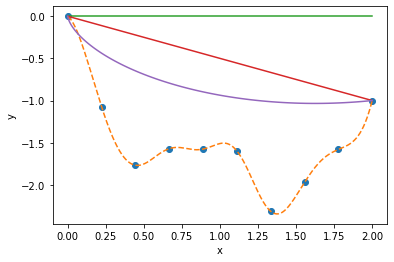

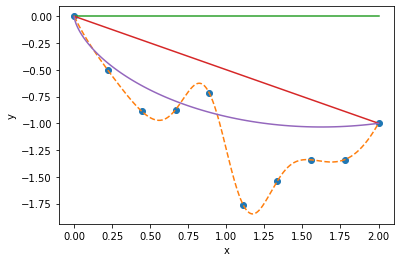

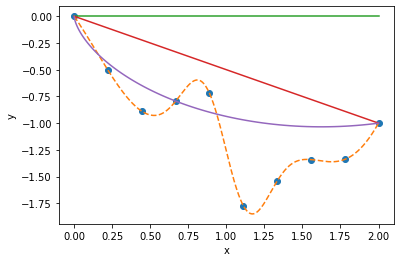

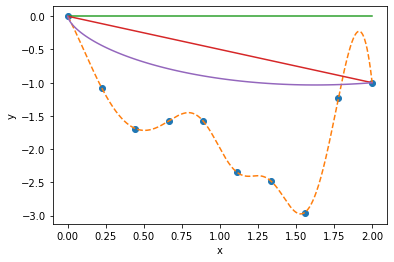

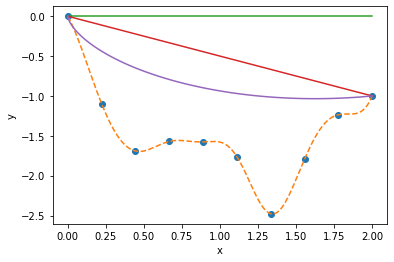

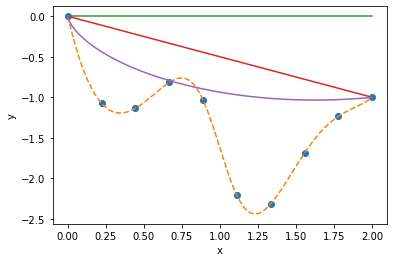

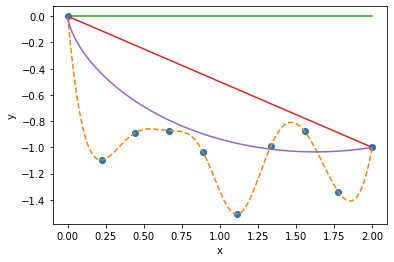

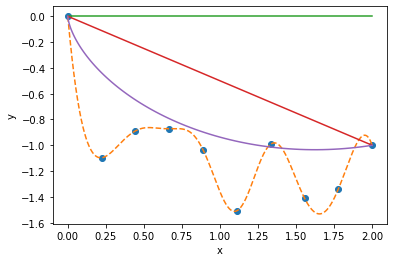

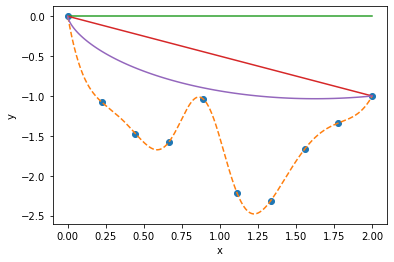

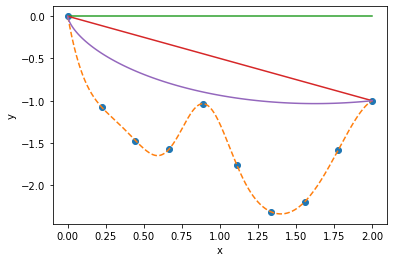

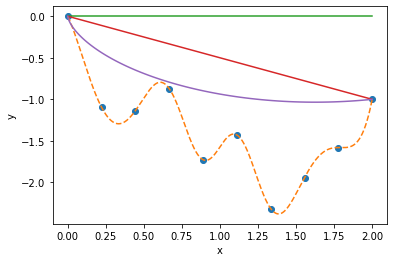

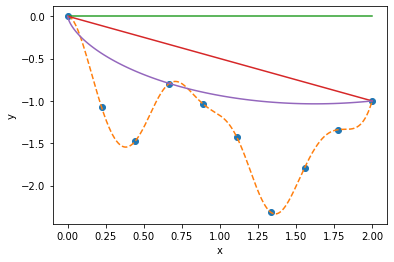

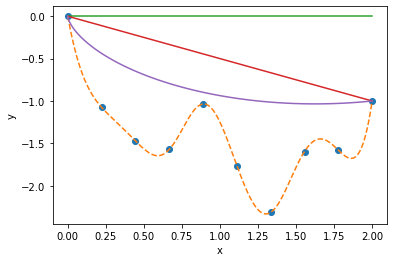

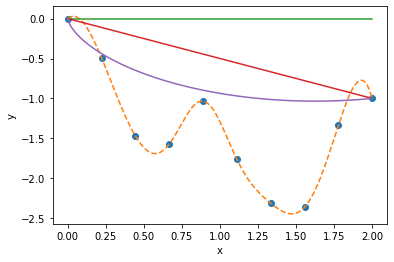

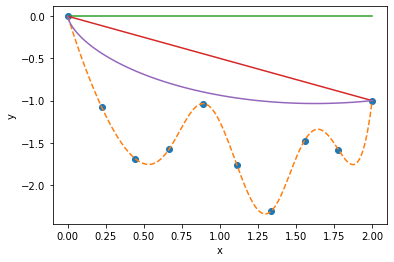

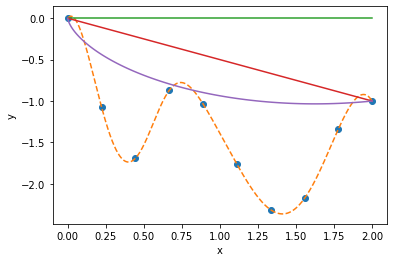

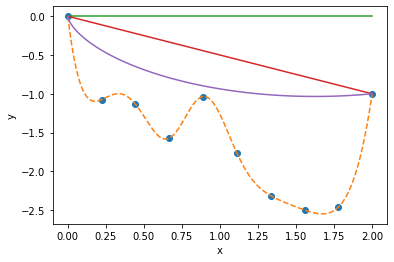

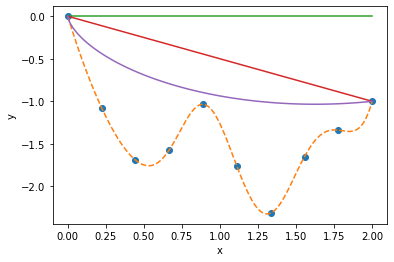

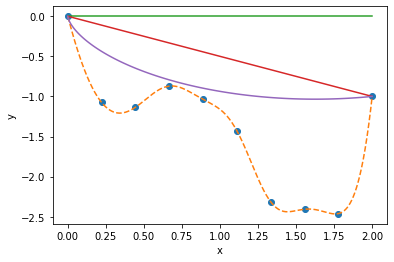

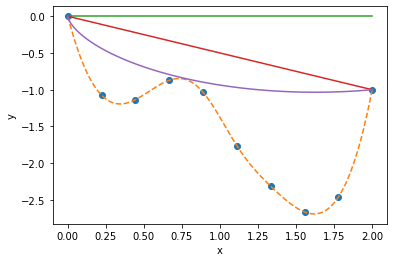

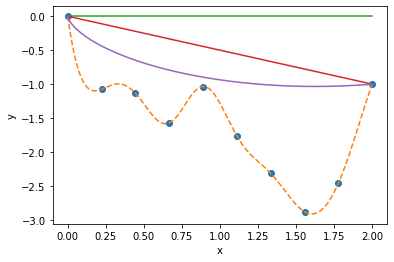

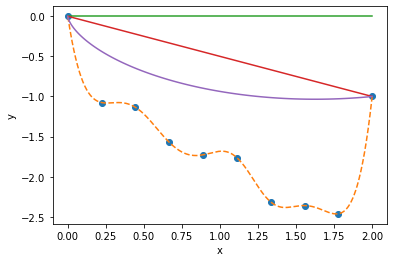

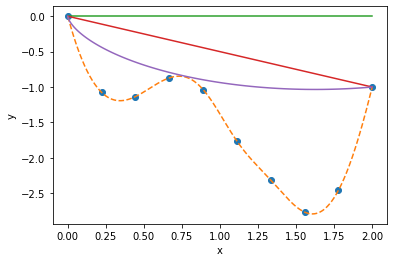

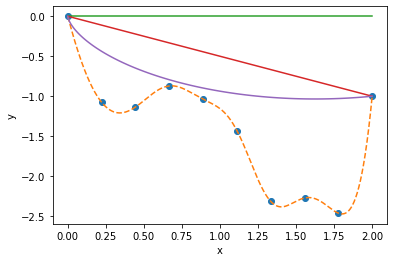

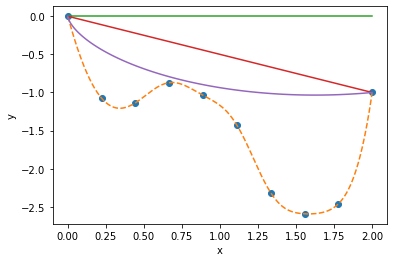

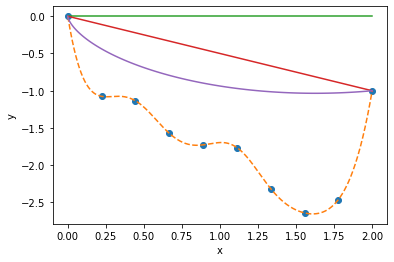

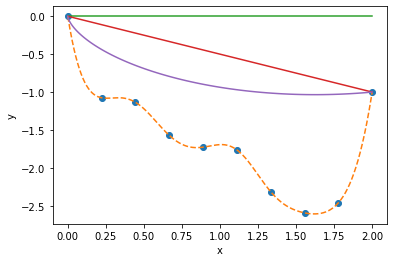

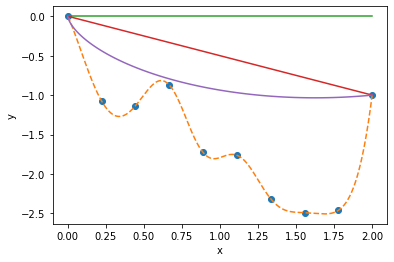

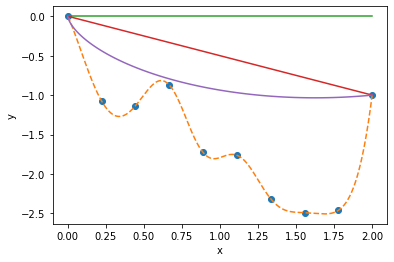

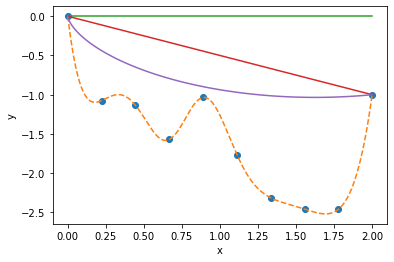

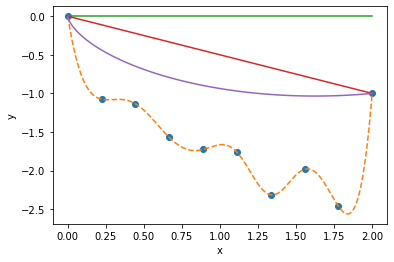

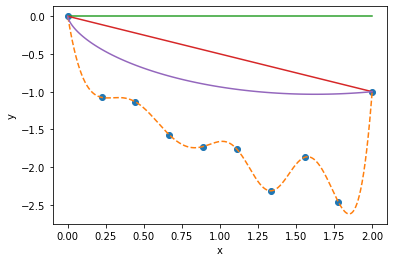

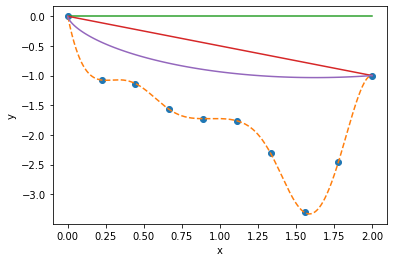

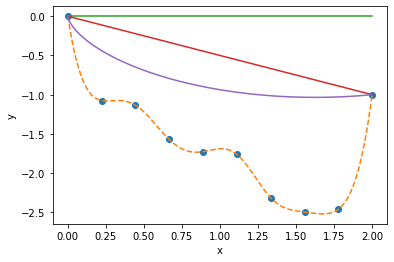

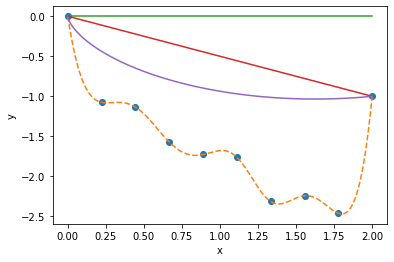

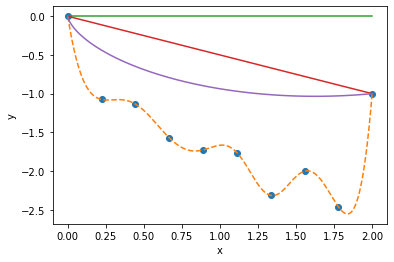

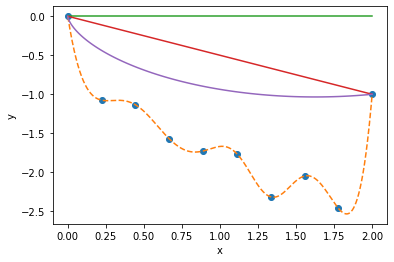

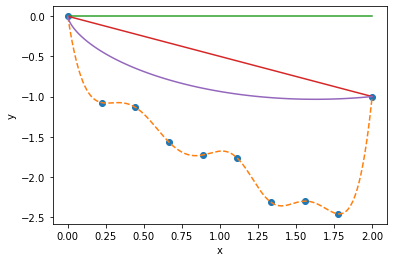

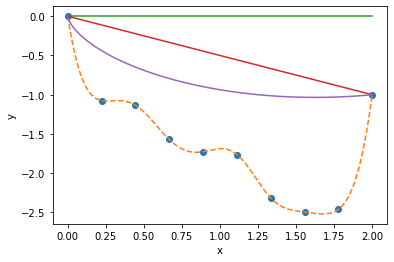

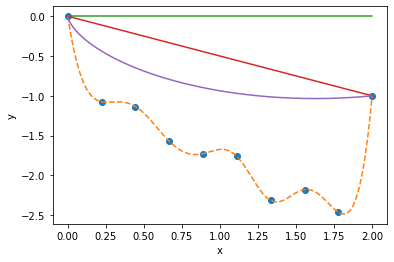

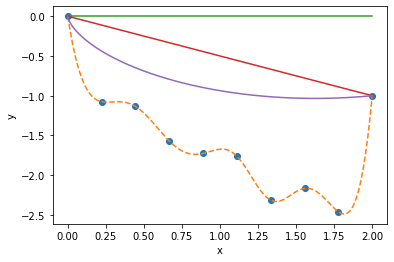

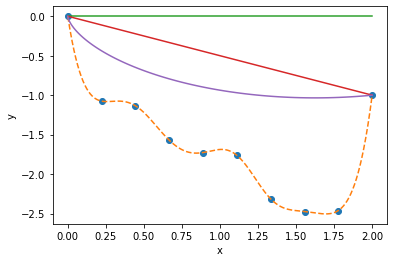

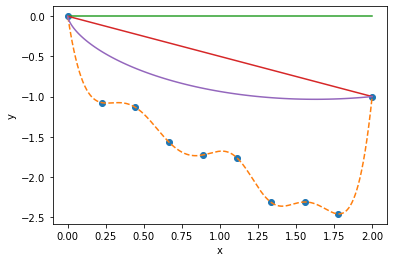

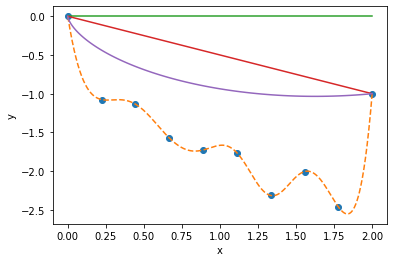

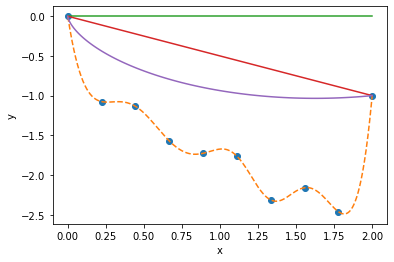

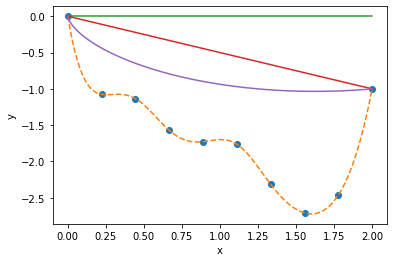

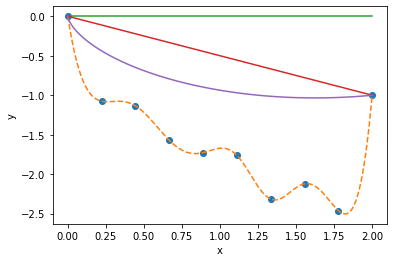

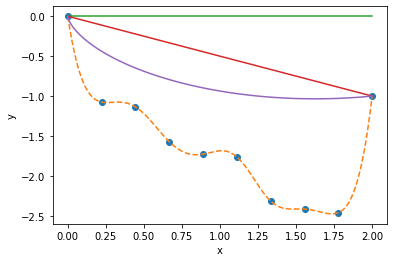

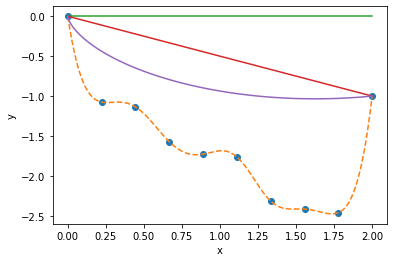

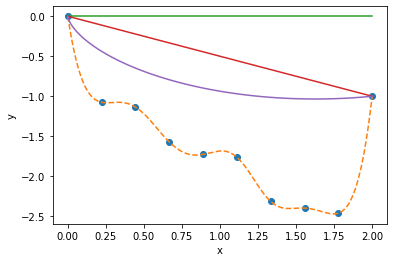

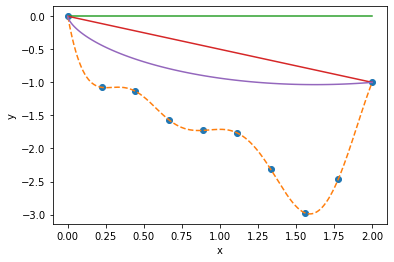

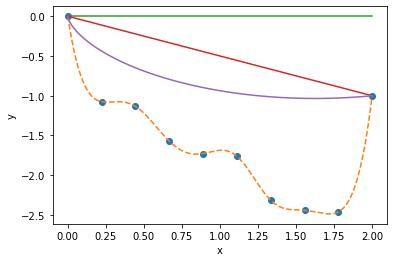

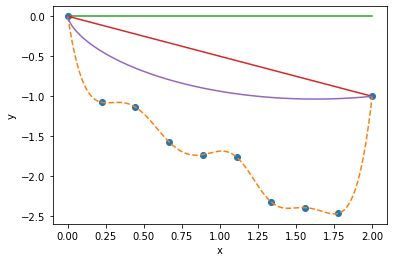

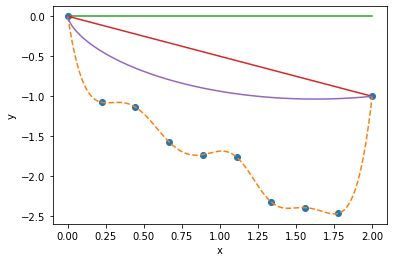

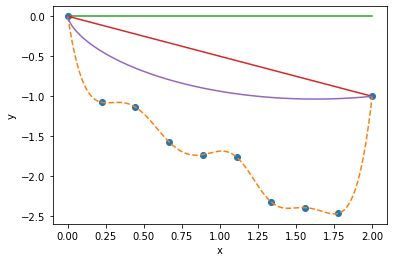

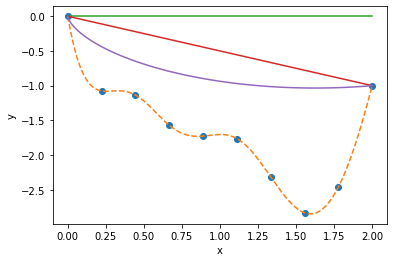

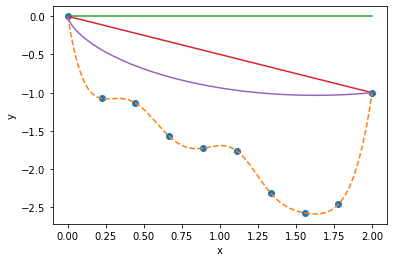

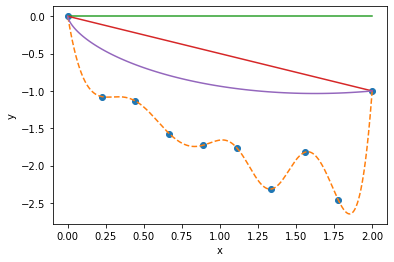

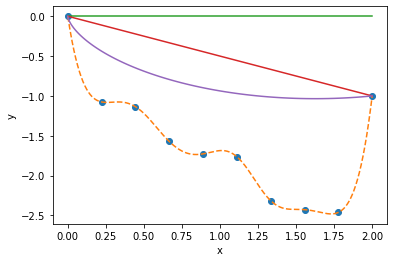

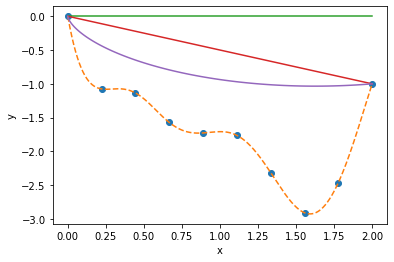

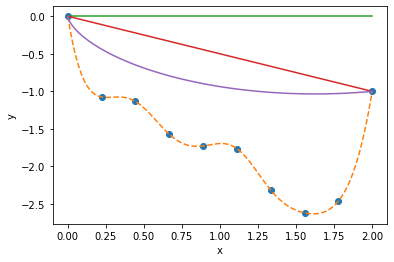

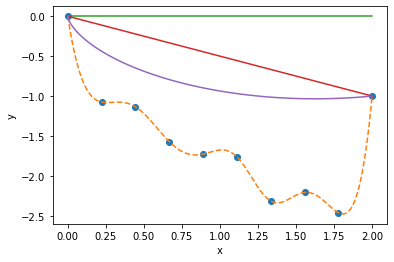

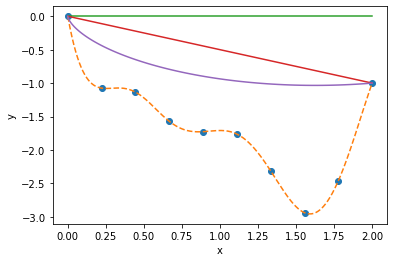

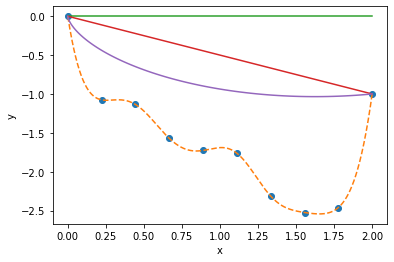

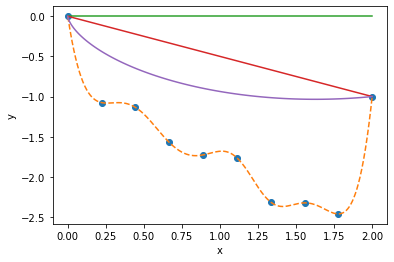

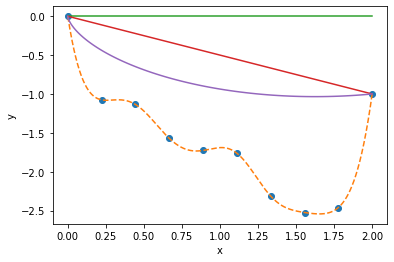

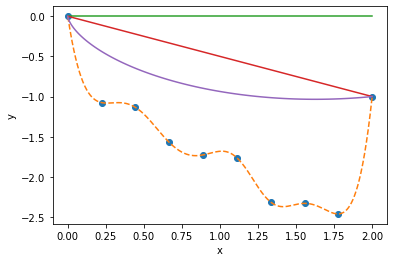

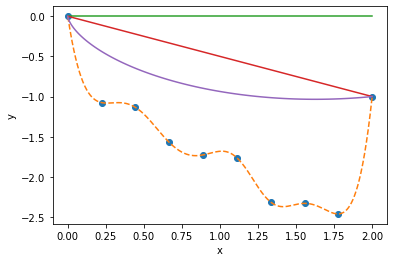

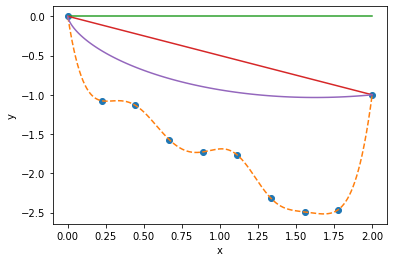

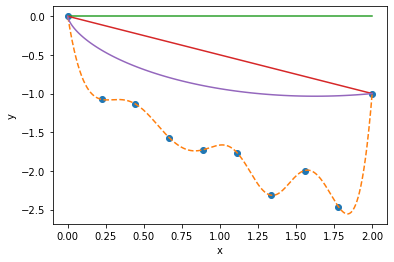

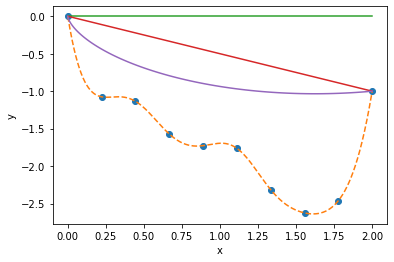

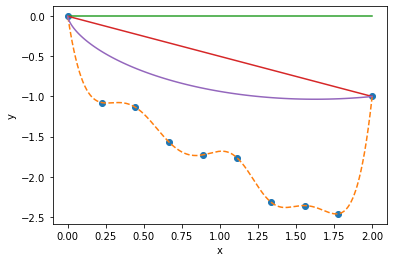

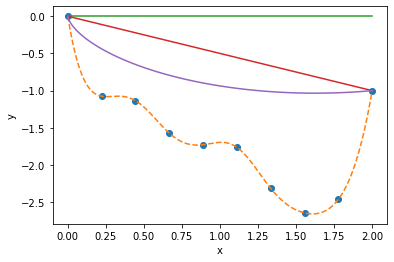

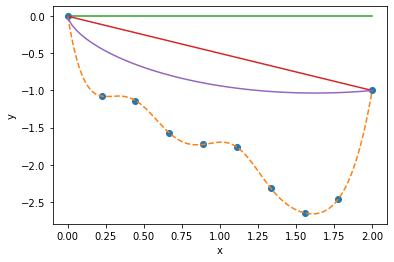

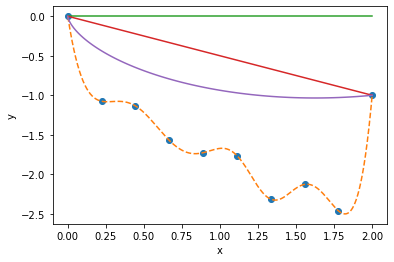

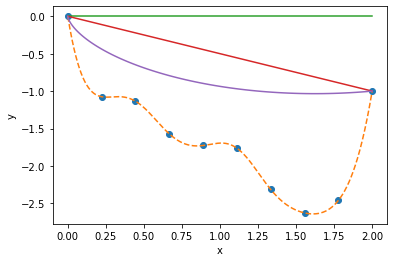

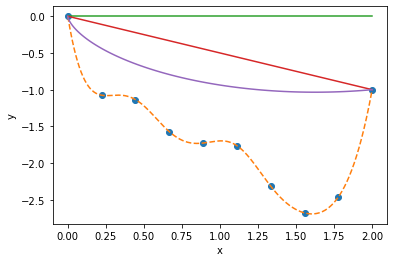

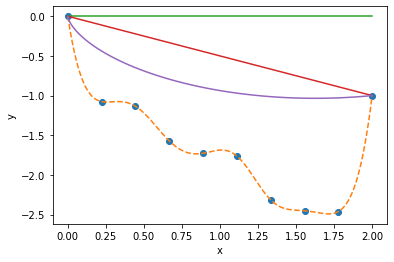

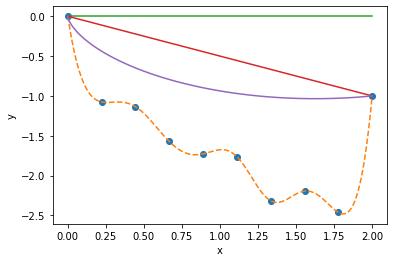

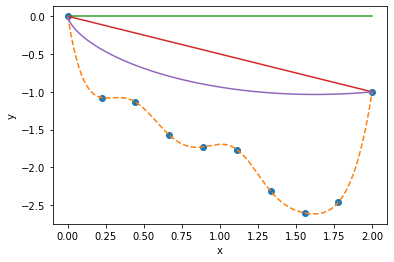

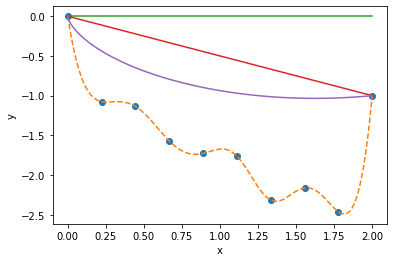

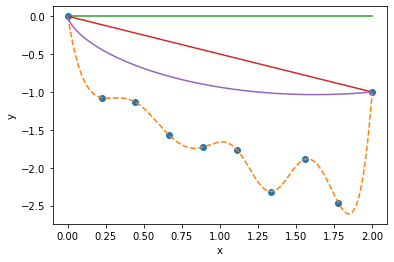

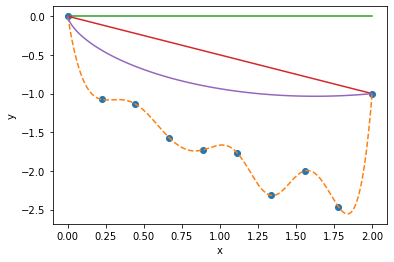

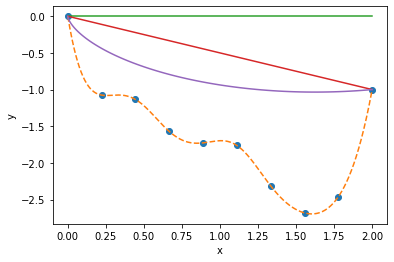

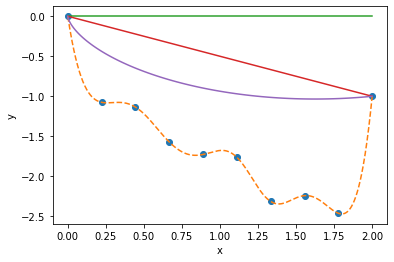

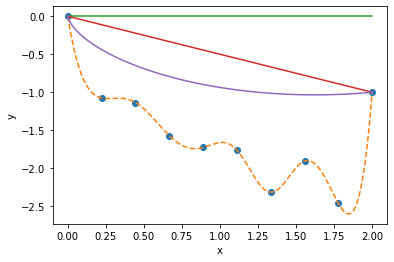

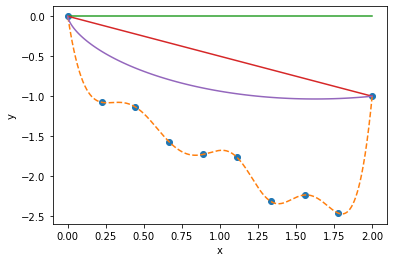

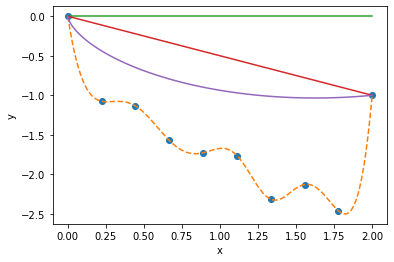

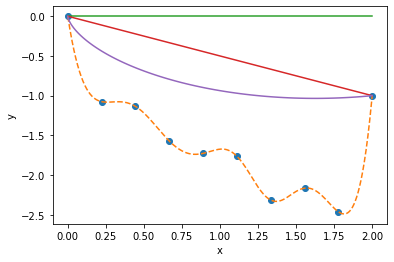

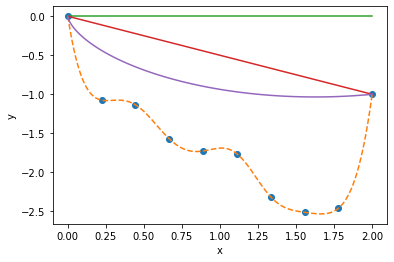

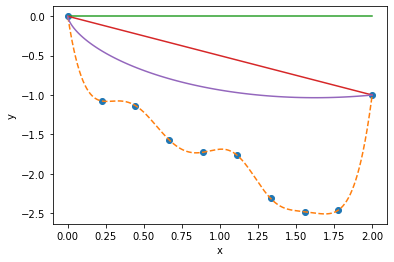

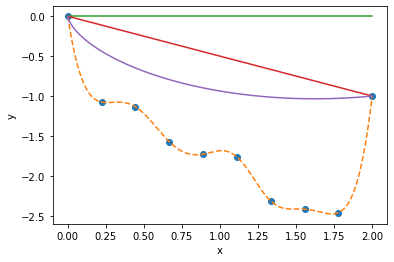

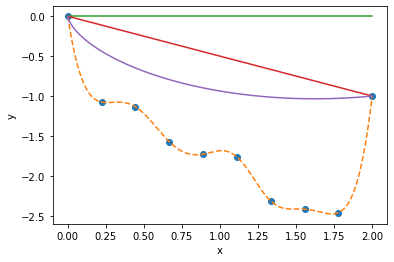

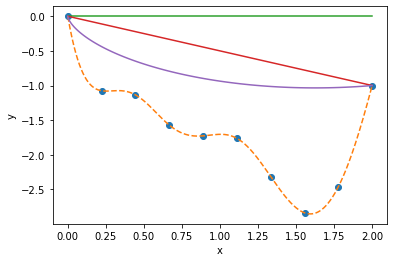

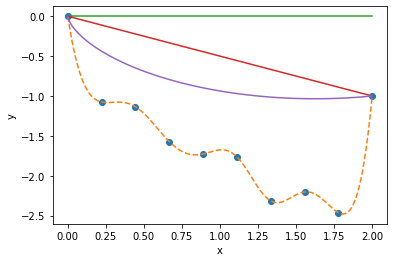

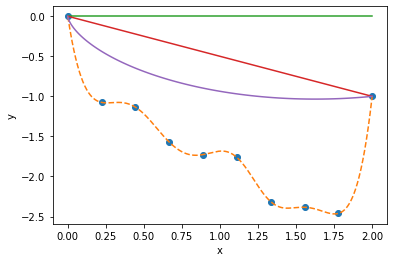

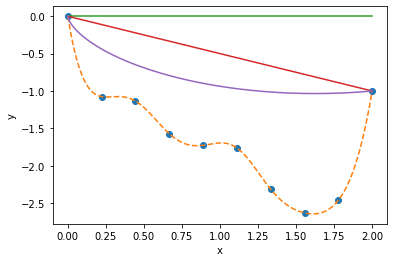

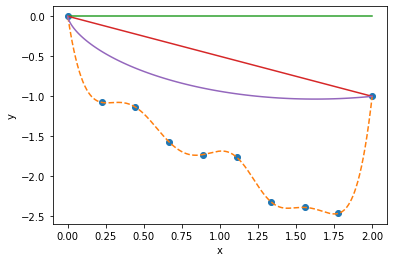

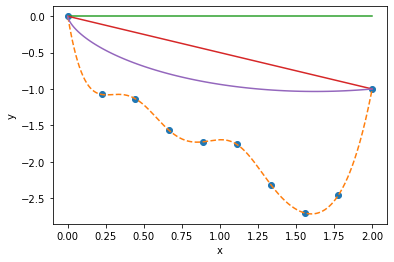

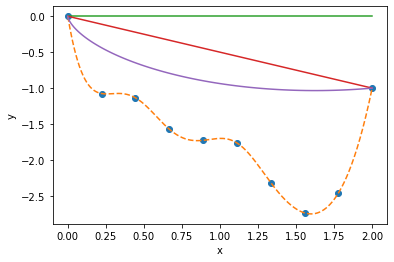

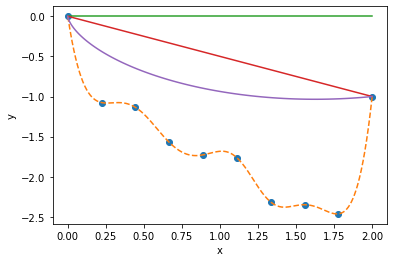

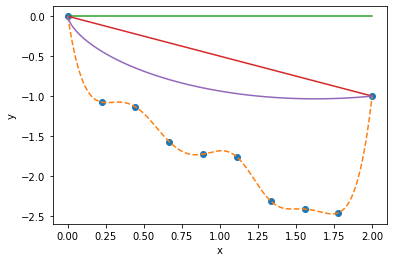

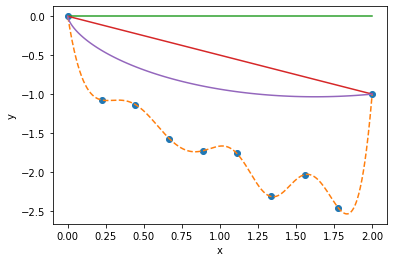

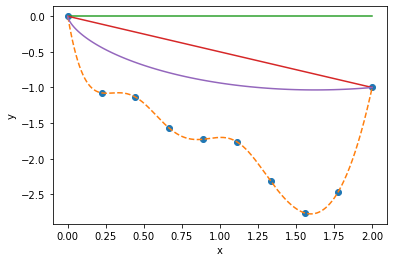

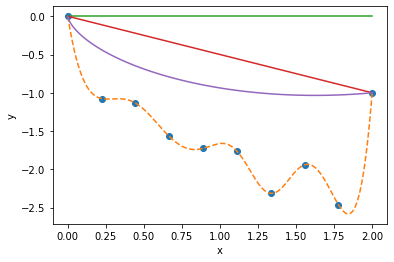

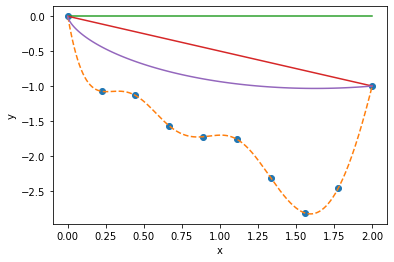

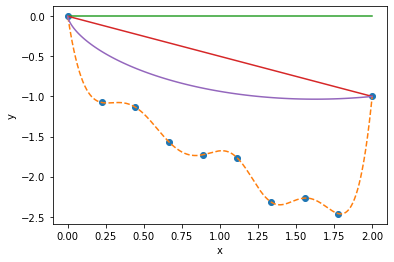

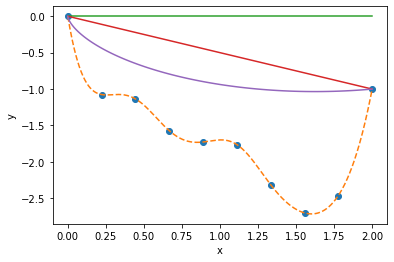

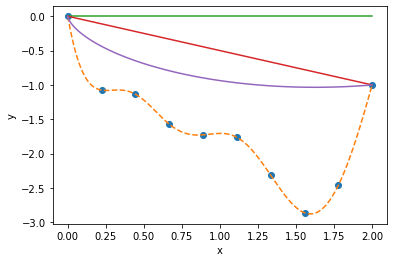

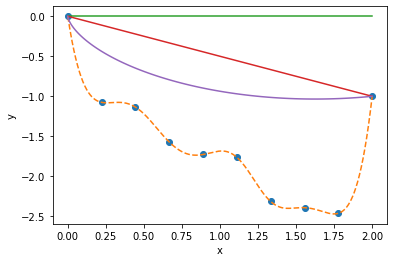

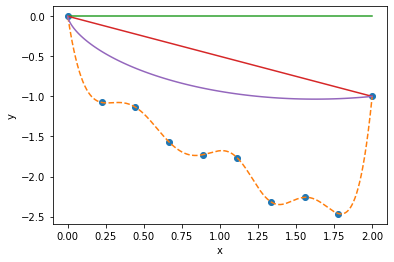

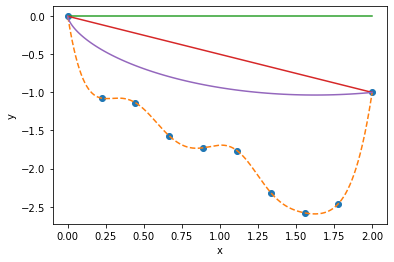

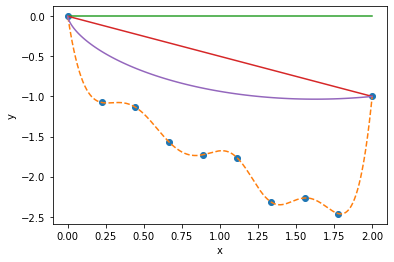

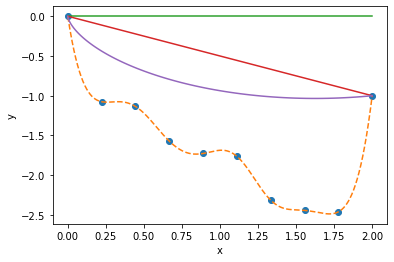

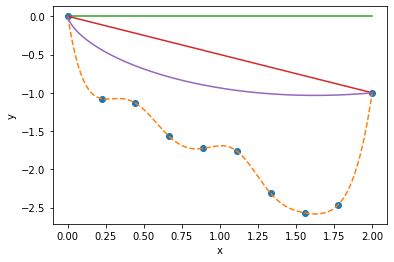

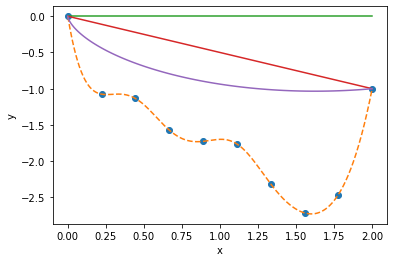

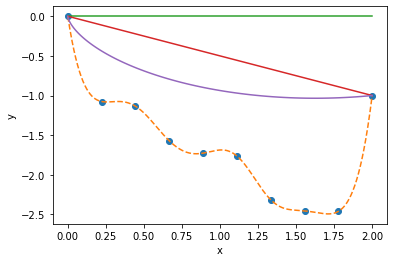

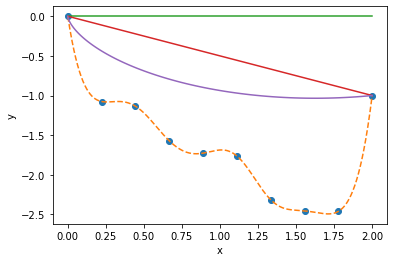

KeyboardInterrupt: ignored

In [18]:
"""GA HYPERPARAMETERS"""
N_POPULATION = 25
N_GENERATION = 5000
RESULTS_SHOW_PERIOD =1
""""""""""""""""""


# test
if __name__ == '__main__':

    pop = Population(N_POPULATION)

    for generation in range(N_GENERATION):
        pop.next_generation()
        if generation % RESULTS_SHOW_PERIOD == 0:
            visualize(pop.generation_best)

        """print("Generation: {} \nBest time: {:.3f} | Average time: {:.3f} | Cycloid time: {:.3f}".format(
              generation, pop.generation_best.time, np.mean(pop.fitness), T_cycloid)
              )"""

        # pop.hist_fitness_and_error()